In [6]:
## the purpose of this notebook will be to make scatterplots of the relationship between all single guide 
## perturbation phenotypes and all paired guide perturbation phenotypes that include a query guide, so to create
## a graphical representation of how GIs are called using the "call_genetic_interactions" notebook

## plots generated using this notebook are used in Figures 2A and 2B

In [1]:
## import modules

import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from scipy import stats
import matplotlib.colors as mcolors

In [2]:
## import data

## for each experiment we want to plot we will need a paired guide phenotype matrix and a single guide phenotype 
## matrix, these are generated in the "call_genetic_interactions" notebook by the "generatePhenotypeMatrix" function

## reference1 map
dmso1_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/dmso1_phenotypes.xlsx',index_col=0)
dmso1_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/dmso1_singles_phenotypes.xlsx',index_col=0)

## atr map
atr_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/atr_phenotypes.xlsx',index_col=0)
atr_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/atr_singles_phenotypes.xlsx',index_col=0)

## reference 2 map
dmso2_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/dmso2_phenotypes.xlsx',index_col=0)
dmso2_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/dmso2_singles_phenotypes.xlsx',index_col=0)

## etoposide map
etop_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/etop_phenotypes.xlsx',index_col=0)
etop_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/etop_singles_phenotypes.xlsx',index_col=0)

## glucose deprivation map
keto_phenotypes = pd.read_excel('/Users/benh/Desktop/GI_data/phenotype_matrices/keto_phenotypes.xlsx',index_col=0)
keto_singles = pd.read_excel('/Users/benh/Desktop/GI_data/singles_phenotypes/keto_singles_phenotypes.xlsx',index_col=0)

## We we also need a singles table to map single guides to genes. This is also generated by the same function and
## the output should be the same across experiments
singles_table = pd.read_excel('/Users/benh/Desktop/GI_data/singles_tables/singles_table.xlsx',index_col=0)


In [3]:
## Define functions for GI calling from the "call_genetic_interactions" notebook

def getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition, returnXerr=False):
    if not returnXerr:
        return singlePhenotypes[variablePosition+'.mean'], \
            phenotypeMatrix.loc[sgRNA,:] if fixedPosition == 'a' else phenotypeMatrix.loc[:,sgRNA], \
            singlePhenotypes.loc[sgRNA, fixedPosition +'.mean']
    else:
        return singlePhenotypes[variablePosition+'.mean'], \
            phenotypeMatrix.loc[sgRNA,:] if fixedPosition == 'a' else phenotypeMatrix.loc[:,sgRNA], \
            singlePhenotypes.loc[sgRNA, fixedPosition +'.mean'], singlePhenotypes[variablePosition+'.std']
    
def quadFitForceIntercept(xdata, ydata, bdata):
    m1 = optimize.fmin(lambda m, x, y: ((m[0]*(x**2) + m[1]*x + bdata - y)**2).sum(), x0=[0.1,0.1], args=(xdata, ydata), disp=0)
    return lambda x1: m1[0]*(np.array(x1)**2) + m1[1]*np.array(x1) + bdata
def linearFitForceIntercept(xdata, ydata, bdata):
    m1 = optimize.fmin(lambda m, x, y: ((m*x + bdata - y)**2).sum(), x0=0.1, args=(xdata, ydata), disp=0)[0]
    return lambda x1: m1*np.array(x1) + bdata


In [4]:
## define a colormap to map deviations from the model (GIs) to
colors = ['gold', 'dimgray', 'mediumturquoise']
cmap1 = mcolors.LinearSegmentedColormap.from_list("yellow_gray_blue", colors)

## Set mix and mix values for the cmap. Note these DONT reflect actual gene averaged and z-score normalized GI 
## values as described in the manuscript
vmin = -0.2
vmax = 0.2

(-1.254327829723244, 0.2434302822410876)

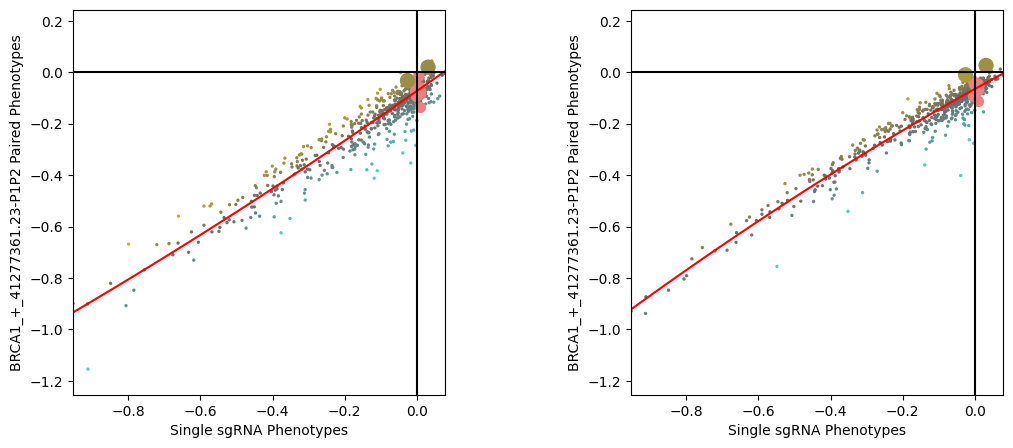

In [8]:
## Select the experiment we want to plot, we need to define a single phenotype matrix and a dual (paired) sgrna ma
single_phenotypes = keto_singles
paired_phenotypes = keto_phenotypes

## Define a query_gene, for which we will calculate models for and generate a plot for each sgRNA

query_gene = 'BRCA1'

## If desired, define a second gene whose sgRNAs will be highlighted on the plot
highlight_gene = 'TP53BP1'


plt.figure(figsize=(12,5))
numPlots = matplotlib.gridspec.GridSpec(1,2,wspace=0.5)

## generate the plot for the first sgRNA
active = plt.subplot(numPlots[0,0])

fit = quadFitForceIntercept

## Grab the phenotype information for the query gene
xdata1,ydata1,bdata1 = getXYB(singles_table.loc[singles_table['gene'] == query_gene].index[0],single_phenotypes,paired_phenotypes,'b','a')

## Generate a model for the query guide 
fit1 = fit(xdata1,ydata1,bdata1)
## Plot the model
quadFit = active.plot(np.arange(xdata1.min()-0.05,xdata1.max()+0.05,0.01),fit1(np.arange(xdata1.min()-0.05,xdata1.max()+0.05,0.01)),c='red')

## Plot all data. Map each point to the color map based off the deviation of the observed value from the model
active.scatter(xdata1,ydata1,s=2,cmap = cmap1,c = fit1(xdata1) - ydata1,vmin=vmin,vmax=vmax)

## Highlight negative controls
active.scatter(xdata1.loc[singles_table['gene'] == 'non-targeting'],ydata1.loc[singles_table['gene'] == 'non-targeting'],s=50,c='lightcoral',label = 'neg-controls')

## Use this line if you want both target sgRNAs, otherwise comment it out
if highlight_gene != False:
    active.scatter(xdata1.loc[singles_table['gene'] == highlight_gene],ydata1.loc[singles_table['gene'] == highlight_gene],
               s=100,cmap=cmap1,c= fit1(xdata1.loc[singles_table['gene'] == highlight_gene])-ydata1.loc[singles_table['gene'] == highlight_gene],
               vmin=vmin,vmax=vmax,label = highlight_gene)

## Define axes, label, and axes limits on plot 
active.plot((0,0),(np.hstack(paired_phenotypes.fillna(0).values).min(),np.hstack(paired_phenotypes.fillna(0).values).max()),color='black')
active.plot((single_phenotypes['b.mean'].min(),single_phenotypes['b.mean'].max()),(0,0),color='black')

plt.xlabel('Single sgRNA Phenotypes')
plt.ylabel(singles_table.loc[singles_table['gene'] == query_gene].index[0]+' Paired Phenotypes')

plt.xlim(single_phenotypes['b.mean'].min(),single_phenotypes['b.mean'].max())
plt.ylim((np.hstack(paired_phenotypes.fillna(0).values).min(),np.hstack(paired_phenotypes.fillna(0).values).max()))


##--------

## generate the plot for the second sgRNA
active = plt.subplot(numPlots[0,1])

## Grab the phenotype information for the query guide
xdata2,ydata2,bdata2 = getXYB(singles_table.loc[singles_table['gene'] == query_gene].index[1],single_phenotypes,paired_phenotypes,'b','a')

## Generate a model for the query gene 
fit2 = fit(xdata2,ydata2,bdata2)

## Plot the model
quadFit = active.plot(np.arange(xdata2.min()-0.05,xdata2.max()+0.05,0.01),fit2(np.arange(xdata2.min()-0.05,xdata2.max()+0.05,0.01)),c='red')

## Plot all data. Map each point to the color map based off the deviation of the observed value from the model
active.scatter(xdata2,ydata2,s=2,cmap = cmap1,c = fit2(xdata2) - ydata2,vmin=vmin,vmax=vmax)

## Highlight negative controls
active.scatter(xdata2.loc[singles_table['gene'] == 'non-targeting'],ydata2.loc[singles_table['gene'] == 'non-targeting'],s=50,c='lightcoral',label = 'neg-controls')

## Use this line if you want both target sgRNAs, otherwise comment it out
if highlight_gene != False:
    active.scatter(xdata2.loc[singles_table['gene'] == highlight_gene],ydata2.loc[singles_table['gene'] == highlight_gene],
               s=100,cmap=cmap1,c= fit1(xdata2.loc[singles_table['gene'] == highlight_gene])-ydata2.loc[singles_table['gene'] == highlight_gene],
               vmin=vmin,vmax=vmax,label = highlight_gene)

## Define axes, label, and axes limits on plot 
active.plot((0,0),(np.hstack(paired_phenotypes.fillna(0).values).min(),np.hstack(paired_phenotypes.fillna(0).values).max()),color='black')
active.plot((single_phenotypes['b.mean'].min(),single_phenotypes['b.mean'].max()),(0,0),color='black')

plt.xlabel('Single sgRNA Phenotypes')
plt.ylabel(singles_table.loc[singles_table['gene'] == query_gene].index[0]+' Paired Phenotypes')

plt.xlim(single_phenotypes['b.mean'].min(),single_phenotypes['b.mean'].max())
plt.ylim((np.hstack(paired_phenotypes.fillna(0).values).min(),np.hstack(paired_phenotypes.fillna(0).values).max()))

